In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time
from tqdm import tqdm
import shutil
import os
import PIL
import keras.backend as K

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices("GPU") 
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

### GitHub

**GitHub link**: TBD

**Kaggle Dataset**: https://www.kaggle.com/competitions/gan-getting-started

**Kaggle Dataset Title**: *I’m Something of a Painter Myself*

Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

## Machine Learning 3: GAN Monet

### Step 1: Brief description of the problem and data:

**Description of project**: The purpose of this notebook is to leverage GAN neural network to produce fake Monet images from provided Photos and ensure that the discriminator passes them as real.

**Description of GAN**: A Generative Adverserial Network is an area within Machine Learning that is used to generate new data resembling existing data. A GAN consists of two neural networks - a generator and a discriminator. Both neural networks compete against each other. For example, the generator produces the fake images that resemble real ones, and the discriminator simultaneously tries to classify them whether they are real (1) or fake (0).

**Desciption of size, dimension, structure of data**: The Monet set has a total **size** of 300 images amd photos has a total size of 7,028 images. The **dimensions** of the data set is provided in three channels (e.g., RGB) and each image dimension is 256x256px. The **structure** of the data is provided in two formats - jpg and TFRecord.

In [4]:
# load folder paths
m_path = "/kaggle/input/gan-getting-started/monet_jpg"
p_path = "/kaggle/input/gan-getting-started/photo_jpg"
mt_path = "/kaggle/input/gan-getting-started/monet_tfrec"
pt_path = "/kaggle/input/gan-getting-started/photo_tfrec"

In [5]:
# count number of monet and photos
m_count = len(os.listdir(m_path))
p_count = len(os.listdir(p_path))
mt_count = len(os.listdir(mt_path))
pt_count = len(os.listdir(pt_path))

# print size of data
print(f' Number of Monet images: {m_count}\n Number of Photo images: {p_count}\n Number of Monet tfrec files: {mt_count}\n Number of Photo tfrec files: {pt_count}')

 Number of Monet images: 300
 Number of Photo images: 7038
 Number of Monet tfrec files: 5
 Number of Photo tfrec files: 20


### Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

I visualized the data in a few different ways. The first visualization I produced is a historgram that shows the breakdown of the sample size across each folder. As shown in the histogram below, we have over 7,000 photos that we can convert into Monet style. Monet consists of only 300 photos. Although there are only 5 TFRecord files in Monet and 20 files in TFRecord this is just a format that allows Tensorflow to intake. Both sets still consists of the same number of photos that are in jpg format.

Next, I produced a random sample of five Monet photos and five real photos to get an idea of how they look visually. Notice how the Monet photos are painted vs. the photos are real photos.

Finally, I produced another visualization where I seperated the R, G, and B channels from five random Monet photos and five random real photos to see if I can identify anything noteworthy. Since the Monet are handpainted vs. real photos are likely digital, I noticed the R, G, B channels in the Monet photos are more saturated and darker in nature. While the real photos are lighter across the three channels - R, G, and B.

<Axes: xlabel='Data folder', ylabel='Count'>

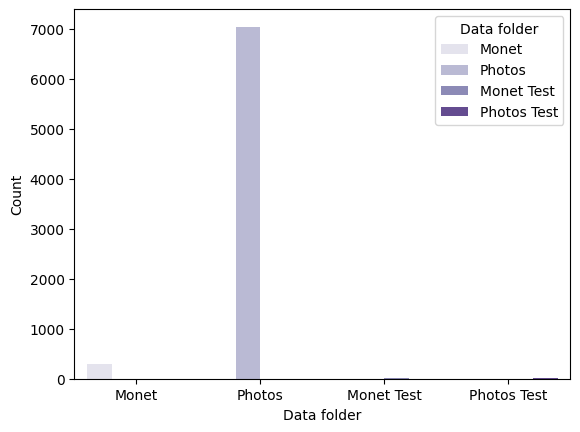

In [6]:
# dict to hold counts
dict_counts = {
    'Data folder' : ['Monet', 'Photos', 'Monet Test', 'Photos Test'],
    'Count' : [m_count, p_count, mt_count, pt_count]
}

# dict to df
df_counts = pd.DataFrame(dict_counts)

sns.barplot(x='Data folder', y='Count', data=df_counts, hue='Data folder', palette = 'Purples')

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


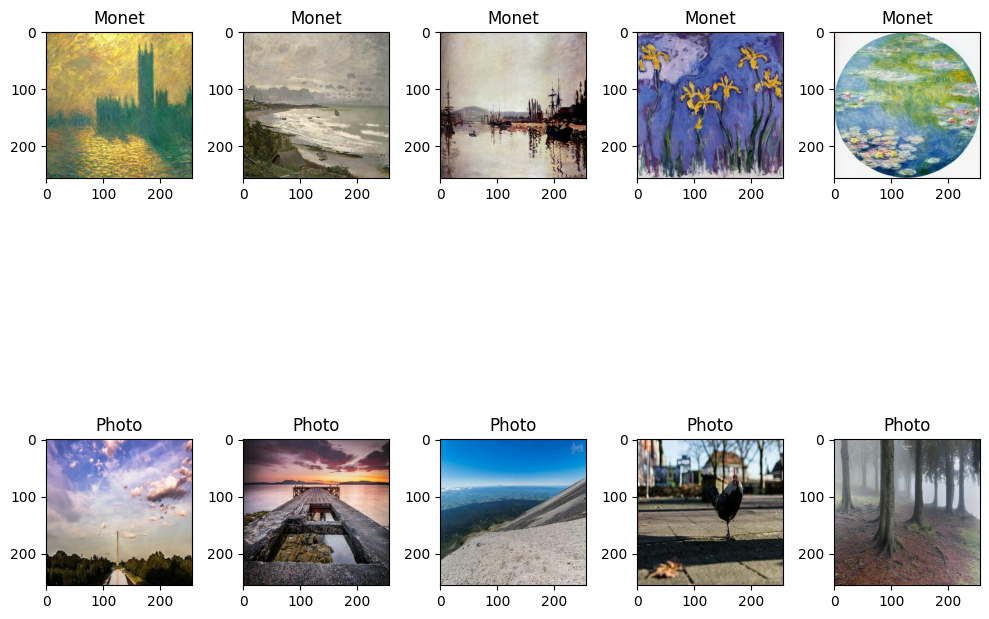

In [7]:
# select 5 random samples from monet and photo
n_samples = 5
sample_monet = random.sample(os.listdir(m_path), n_samples)
sample_photo = random.sample(os.listdir(p_path), n_samples)

# plot 5 random samples of monet and photo
plt.figure(figsize=(10,10))

# monet plot
for i, file in enumerate(sample_monet):
    file_path = os.path.join(m_path, file)
    plt.subplot(2, n_samples, i+1)
    img = mpimg.imread(file_path)
    plt.title('Monet')
    print(img.shape)
    plt.imshow(img)

# photo plot
for i, file in enumerate(sample_photo):
    file_path = os.path.join(p_path, file)
    plt.subplot(2, n_samples, i+1+n_samples)
    img = mpimg.imread(file_path)
    plt.title('Photo')
    print(img.shape)
    plt.imshow(img)

plt.tight_layout()

In [8]:
# helper function to plot RGB
def rgb(img):
    # load img using OpenCV
    img = cv2.imread(img)
    # seperate img to RGB channels
    r,g,b = cv2.split(img)
    # plot
    plt.figure(figsize=(12,5))
    # red channel
    plt.subplot(1,3,1)
    plt.imshow(r,cmap='Reds')
    # green channel
    plt.subplot(1,3,2)
    plt.imshow(g,cmap='Greens')
    # blue channel
    plt.subplot(1,3,3)
    plt.imshow(b,cmap='Blues')
    plt.tight_layout()
    plt.show()   

### Monet RGB filters
Notice how Monet RGB colors appear to be more saturated and darker

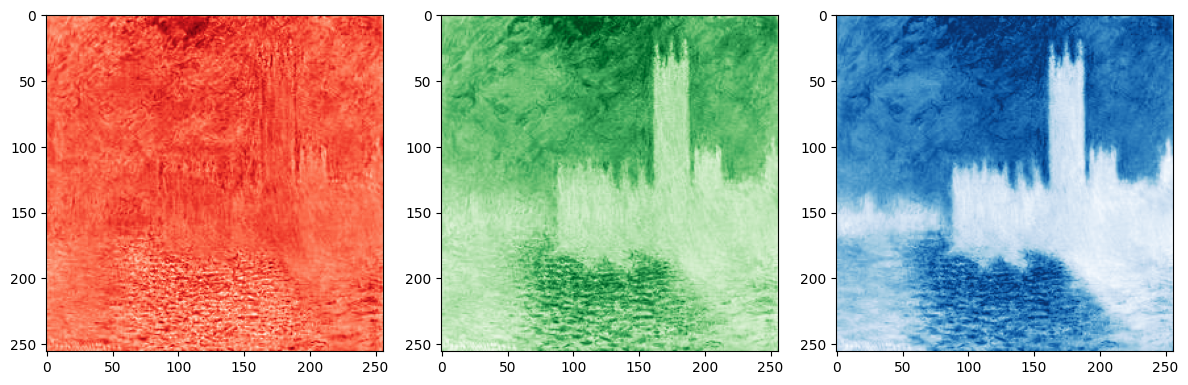

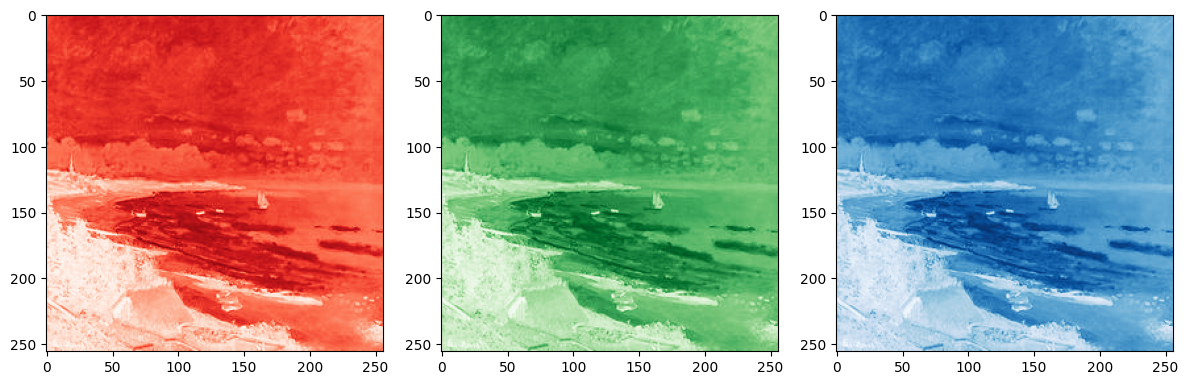

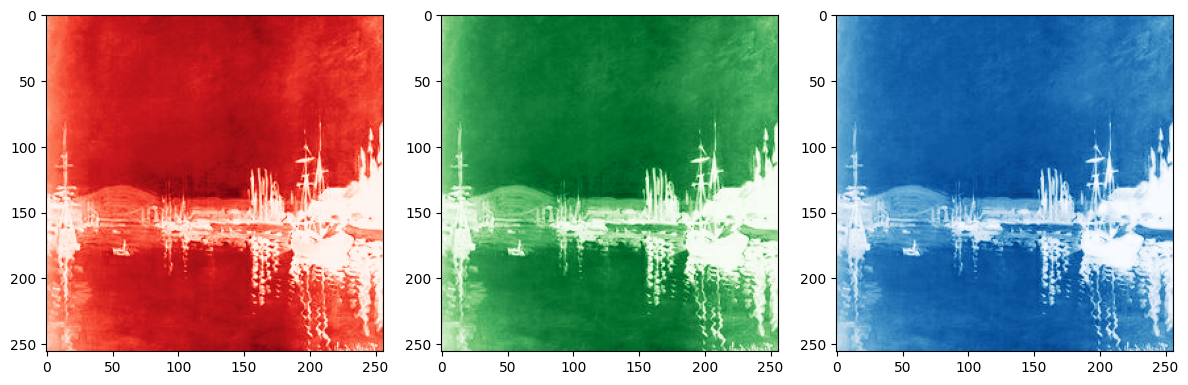

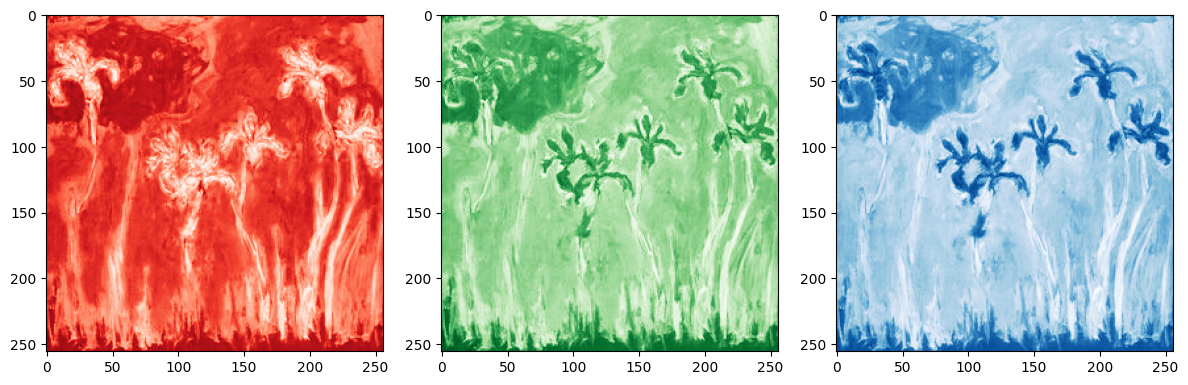

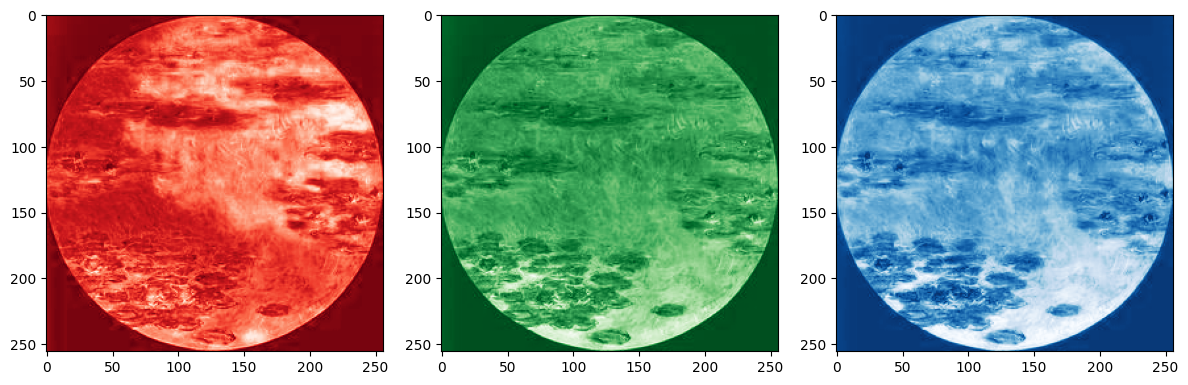

In [9]:
for sample in sample_monet:
    rgb(os.path.join(m_path,sample))

### Photo RGB filters
While, photos look to be a lot lighter when comparing against their RGB filters

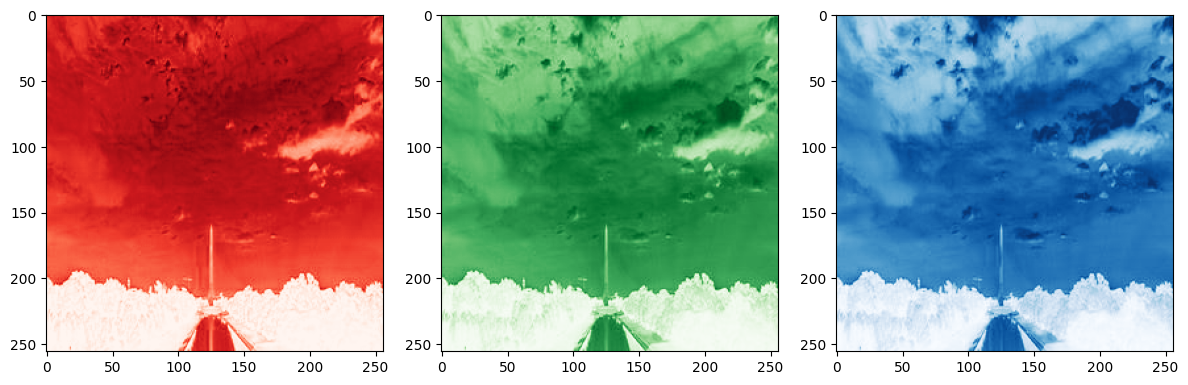

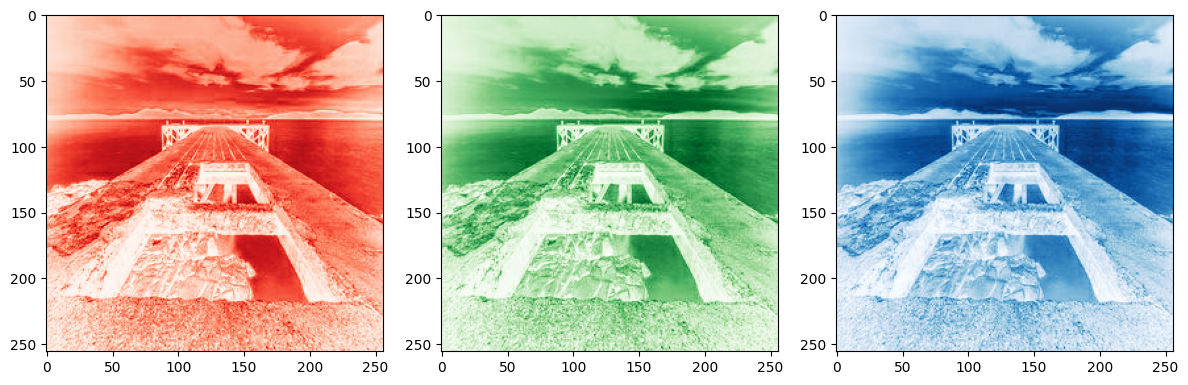

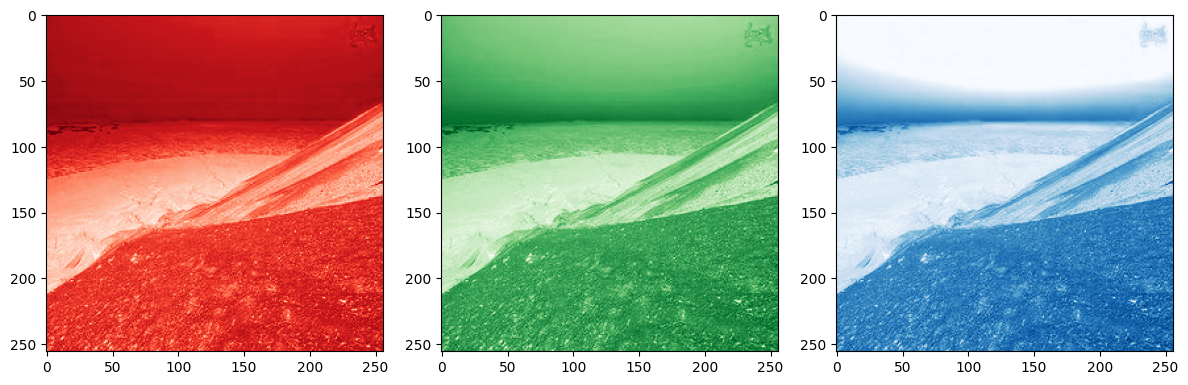

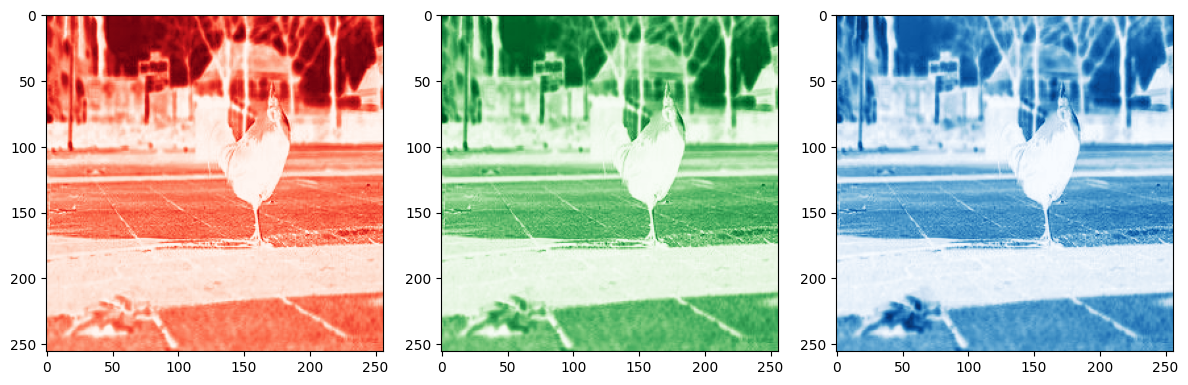

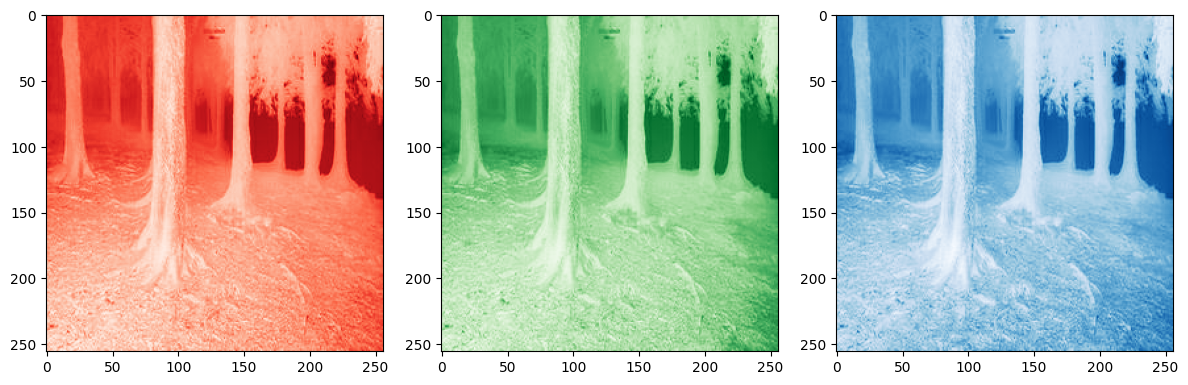

In [10]:
for sample in sample_photo:
    rgb(os.path.join(p_path,sample))

### Data preprocessing and augmentation

Before jumping into the model step, I need to first process and load the data correctly for the GAN architecture. I will create several helper functions that will make the model step smoother. First I create the img_load function that takes the img_path and normalizes the img pixels (255 for 3 channel RGB) to have values between -1 and 1. The this is accomplished is dividing 255 by half (127.5) and subtracting 1. Then I created an augment function which does several things to the training set (monet jpgs). First, it randomly rotates the img, then it randomly crops the imgs, and also zooms into the the img at a specified range of intensity. I than resize this randomly augmented img with padding to ensure the output is 256x256px. Lastly, both of these functions roll up into the load_data function where I create tensor slices and shuffle them into a single batch and ready it for the model step. I created a second load function called `load_data_photo` for the purposes of loading the photos without the augment step as the test data set for preditions. You can see I commented out the augment portion of the code in that function. The goal with the augment step is to add variation to the images in hopes that the model will train better and improve performance results.

In [11]:
# helper function to load img
def img_load(img_path):
    img = load_img(img_path,target_size=(256,256))
    img = img_to_array(img)
    # normalize img px values to [-1,1] - 
    # since its RGB (255 px vluaes) we can divide by half or 127.5 and subtract 1 
    img = (img.astype('float32')/127.5) -1
    return img

In [12]:
# helper function to augment images for better training results -
# idea obtained from ML3 week 5 lecture
def augment(img):
    # random rotation
    img = tf.image.rot90(img, k=random.randint(0,3))
    # random cropping
    img = tf.image.random_crop(img, size=[256,256,3])
    # random zoom
    zoom_intensity = random.uniform(0.75,1.25)
    img = tf.image.resize(img,[int(256*zoom_intensity), int(256*zoom_intensity)])
    img = tf.image.resize_with_crop_or_pad(img, 256,256)
    return img

In [13]:
# helper function to load data
def load_data(img_dir):
    imgs=[]
    for each_img in os.listdir(img_dir):
        img_path = os.path.join(img_dir,each_img)
        img = img_load(img_path)
        img = augment(img)
        imgs.append(img)
    df = tf.data.Dataset.from_tensor_slices(imgs)
    df = df.shuffle(buffer_size=len(imgs)).batch(1)
    return df

In [14]:
# helper function to load data without augment
def load_data_photo(img_dir):
    imgs=[]
    for each_img in os.listdir(img_dir):
        img_path = os.path.join(img_dir,each_img)
        img = img_load(img_path)
        #img = augment(img)
        imgs.append(img)
    df = tf.data.Dataset.from_tensor_slices(imgs)
    df = df.shuffle(buffer_size=len(imgs)).batch(1)
    return df

In [15]:
# load monet df with augment
monet_df = load_data(m_path)

In [16]:
# load photo df without augment
photo_df = load_data_photo(p_path)

### Model Architecture

**Description of model architecture**:

I have formed 2 CycleGAN architectures where one is simpler than the other to test performance and compare results. In general, a GAN model requires a generator function and a discriminator function that competes with one another. For example, the generator produces the images and acts as a predictor while the discriminator acts as a validation to check whether the image passes the real or fake test. The model iterates through these steps numerous times to try and improve the generator loss and discriminator loss.

The simpler model uses less layers and smaller kernel sizes compared to the more complex model. This could be a benefit for faster training and less computing power usage. I wanted to see if this set-up would have less overfitting potential. Looking at the more complex generator, I have added additional convolution layers in hopes that the model would learn more complex patterns from the data and produce a better monet like image compared to the simpler model. The reason I chose tanh in the final convolution layer for both models is because research showed its the appropriate one to use for our normalized images values are between -1 and 1. Additionally, I tried to increase the complex models filters to a larger number compared to the simpler model to ensure I capture the specific monet style patterns that can be used to generate on towards the real photos. For both models I leveraged Leaky ReLU activations. The purpose of this is to mitigate the vanishing gradient problem as discussed in the lectures. I finally wrapped both models with a sigmoid output layer which produces a probability whether the input image is real or fake in the discriminator function.

Moving on to the loss functions, the generator loss function is based on a binary crossentropy. The idea is to see how well the generator can produce like monet images from the real photos and see if the model can bypass the discriminator for tricking it to think it its a real monet. Discriminator loss takes the real and fake images using the same binary crossentropy method to learn how to accurately classify real and fake images. Both loss functions are important as the goal is for each to compete against each other to increase performance.

The cycle loss was a new concept for me in learning how to architect the CycleGAN model. The way I understand it is the goal of it is to encourage the framework to translate images back and forth. For example, translate monet to photo and then photo to monet while retaining content. The idea behind it is to help retain important features.

*Source: https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/*

**Hyperparameter tuning**:

Based on research, it seems that Adam optimizer is a good choice when it comes to GAN models. I have left the default settings for both simpler and complex models. I did hand-tune the model in the more complex version by adding more layers, adjusting the kernel_sizes and increasing to larger filters. I have also included Leaky ReLU as outlined earlier to ensure I mitigate the vanishing gradient problem. I could have played with the learning rate of Adam optimizer by setting it to a value such as 0.0001 instead of using the default. However, the training time on this was significant and I decided to retain the default values.

**Compare multiple architectures/loss functions**:

As outlined earlier, I provided an overview on the differences between the simpler and complex model. In terms of the loss functions, I kept them the same to ensure I can compare the models performance on the different architectures that I set up between the simpler and complex model. Changing multiple aspects at the same time would make it difficult to evaluate what worked vs. what didn't. Especially, in such a complex set-up as a GAN.

### Simpler Generator / Discriminator

In [17]:
# below is the structure of the generator portion of the GAN model
def build_generator_simpler():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(3, kernel_size=5, padding='same', activation='tanh')
    ])
    return model

# below is the structure of the discriminator portion of the GAN model
def build_discriminator_simpler():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu'),
        tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same', activation='leaky_relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

### Complex Generator / Discriminator

In [18]:
# below is the structure of the generator portion of the GAN model
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=7, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(3, kernel_size=7, padding='same', activation='tanh')
    ])
    return model

# below is the structure of the discriminator portion of the GAN model
def build_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
        tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

### Simpler Generator / Discriminator / Cycle Loss

In [19]:
# below is a helper function for the generator loss function which takes the average between
# real loss and fake loss to produce a loss figure (the lower th better)
def generator_loss_simpler(fake):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake), fake)

# below is a helper function for the discriminator loss function which takes the average between
# real loss and fake loss to produce a loss figure (the lower th better)
def discriminator_loss_simpler(real, fake):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake), fake)
    return tf.reduce_mean(real_loss + fake_loss)

# cycle loss for translating image back to original
def cycle_loss_simpler(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

### Complex Generator / Discriminator / Cycle Loss

In [20]:
# below is a helper function for the generator loss function which takes the average between
# real loss and fake loss to produce a loss figure (the lower th better)
def generator_loss(fake):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake), fake)

# below is a helper function for the discriminator loss function which takes the average between
# real loss and fake loss to produce a loss figure (the lower th better)
def discriminator_loss(real, fake):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake), fake)
    return tf.reduce_mean(real_loss + fake_loss)

# cycle loss for translating image back to original
def cycle_loss(real_image, cycled_image, lambda_cycle=10):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss

### Simpler Model Compile

In [21]:
# to clear session everytime we run this to begin from session 0
K.clear_session()

# create the models based on the helper functions above
m_generator_s = build_generator_simpler()
p_generator_s = build_generator_simpler()
m_discriminator_s = build_discriminator_simpler()
p_discriminator_s = build_discriminator_simpler()

### Complex Model Compile

In [22]:
# to clear session everytime we run this to begin from session 0
K.clear_session()

# create the models based on the helper functions above
m_generator = build_generator()
p_generator = build_generator()
m_discriminator = build_discriminator()
p_discriminator = build_discriminator()

### Simpler Architecture CycleGAN - Model 1

In [23]:
m_generator_s.summary()
m_discriminator_s.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 32)   │        51,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 3)    │         2,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,331 (419.26 KB)

 Trainable params: 107,331 (419.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       262,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,841 (1.20 MB)

 Trainable params: 315,841 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

### More Complex Architecture Hyperparameter Tuned CycleGAN - Model 2

In [24]:
m_generator.summary()
m_discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 128, 128, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 256, 256, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 3)    │         9,411 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,739 (2.89 MB)

 Trainable params: 756,739 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       524,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,625 (2.51 MB)

 Trainable params: 658,625 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

### Simpler Optimizer Assignment

In [25]:
# default Adam optimizer for cycleGAN model
m_generator_s_optimizer = tf.keras.optimizers.Adam()
p_generator_s_optimizer = tf.keras.optimizers.Adam()
m_discriminator_s_optimizer = tf.keras.optimizers.Adam()
p_discriminator_s_optimizer = tf.keras.optimizers.Adam()

### Complex Optimizer Assignment

In [26]:
# default Adam optimizer for cycleGAN model
m_generator_optimizer = tf.keras.optimizers.Adam()
p_generator_optimizer = tf.keras.optimizers.Adam()
m_discriminator_optimizer = tf.keras.optimizers.Adam()
p_discriminator_optimizer = tf.keras.optimizers.Adam()

### Simpler Training Function

Since a GAN model does not have a library where we can leverage `.compile()` and `.fit()` functions. The next two pair blocks of code are functions that act as `.fit`. The below code is not entirely mine. Although I tweaked the code to fit what I was trying to achieve, I did leverage the help from the work of Amy Jang which is referenced in the Kaggle instructions as a tutorial to the competition. This is also included in the references section and I wanted to ensure I acknowledge her work.

*Source: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial*

In [27]:
# train model using custom training method
# I researched several Kaggle workbooks in this competition to get a sense of what was
# required to make this work - I leveraged some of this code from those workbooks
def train_simpler(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # generate fake images
        fake_photo = m_generator_s(real_monet, training=True)
        cycled_monet = p_generator_s(fake_photo, training=True)

        fake_monet = p_generator_s(real_photo, training=True)
        cycled_photo = m_generator_s(fake_monet, training=True)

        # discriminator output
        disc_real_monet = m_discriminator_s(real_monet, training=True)
        disc_real_photo = p_discriminator_s(real_photo, training=True)

        disc_fake_monet = m_discriminator_s(fake_monet, training=True)
        disc_fake_photo = p_discriminator_s(fake_photo, training=True)

        # calculate losses
        gen_monet_loss = generator_loss(disc_fake_monet)
        gen_photo_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        total_gen_monet_loss = gen_monet_loss + total_cycle_loss
        total_gen_photo_loss = gen_photo_loss + total_cycle_loss

        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # calculate grads
    m_generator_grads = tape.gradient(total_gen_monet_loss, m_generator_s.trainable_variables)
    p_generator_grads = tape.gradient(total_gen_photo_loss, p_generator_s.trainable_variables)

    m_discriminator_grads = tape.gradient(disc_monet_loss, m_discriminator_s.trainable_variables)
    p_discriminator_grads = tape.gradient(disc_photo_loss, p_discriminator_s.trainable_variables)

    # apply grads
    m_generator_s_optimizer.apply_gradients(zip(m_generator_grads, m_generator_s.trainable_variables))
    p_generator_s_optimizer.apply_gradients(zip(p_generator_grads, p_generator_s.trainable_variables))

    m_discriminator_s_optimizer.apply_gradients(zip(m_discriminator_grads, m_discriminator_s.trainable_variables))
    p_discriminator_s_optimizer.apply_gradients(zip(p_discriminator_grads, p_discriminator_s.trainable_variables))

    return (total_gen_monet_loss, total_gen_photo_loss, disc_monet_loss, disc_photo_loss)


### Complex Training Function

In [28]:
# train model using custom training method
# I researched several Kaggle workbooks in this competition to get a sense of what was
# required to make this work - I leveraged some of this code from those workbooks
def train_complex(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # generate fake images
        fake_photo = m_generator(real_monet, training=True)
        cycled_monet = p_generator(fake_photo, training=True)

        fake_monet = p_generator(real_photo, training=True)
        cycled_photo = m_generator(fake_monet, training=True)

        # discriminator output
        disc_real_monet = m_discriminator(real_monet, training=True)
        disc_real_photo = p_discriminator(real_photo, training=True)

        disc_fake_monet = m_discriminator(fake_monet, training=True)
        disc_fake_photo = p_discriminator(fake_photo, training=True)

        # calculate losses
        gen_monet_loss = generator_loss(disc_fake_monet)
        gen_photo_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        total_gen_monet_loss = gen_monet_loss + total_cycle_loss
        total_gen_photo_loss = gen_photo_loss + total_cycle_loss

        disc_monet_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_photo_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # calculate grads
    m_generator_grads = tape.gradient(total_gen_monet_loss, m_generator.trainable_variables)
    p_generator_grads = tape.gradient(total_gen_photo_loss, p_generator.trainable_variables)

    m_discriminator_grads = tape.gradient(disc_monet_loss, m_discriminator.trainable_variables)
    p_discriminator_grads = tape.gradient(disc_photo_loss, p_discriminator.trainable_variables)

    # apply grads
    m_generator_optimizer.apply_gradients(zip(m_generator_grads, m_generator.trainable_variables))
    p_generator_optimizer.apply_gradients(zip(p_generator_grads, p_generator.trainable_variables))

    m_discriminator_optimizer.apply_gradients(zip(m_discriminator_grads, m_discriminator.trainable_variables))
    p_discriminator_optimizer.apply_gradients(zip(p_discriminator_grads, p_discriminator.trainable_variables))

    return (total_gen_monet_loss, total_gen_photo_loss, disc_monet_loss, disc_photo_loss)


### Simpler Fit Function

The fit function below is lengthy but not too complex when you dive into it. The goal for me was to mimic the progress bar that we get from using the `.fit()` function to monitor training progress of each epoch. I have assigned `progress_bar` to the tqdm function and produced average gen loss for both monet and photo as well ass avg disc loss for both monet and photo to update live within the progress bar as training iterates through the 300 monet photos. I then output these once training is fnished so that I can produce plots on these metrics to evaluate the results and compare between the simpler and complex function.

In [29]:
def fit_simpler(data_monet, data_photo, epochs=100):
    
    # initialize empty lists to store losses
    avg_gen_monet_losses_s = []
    avg_gen_photo_losses_s = []
    avg_disc_monet_losses_s = []
    avg_disc_photo_losses_s = []

    # iterate over each epoch
    for epoch in range(epochs):
        start_time = time.time()

        # initialize storage total losses so we can then calculate average loss for each metric
        total_gen_monet_loss = 0.0
        total_gen_photo_loss = 0.0
        total_disc_monet_loss = 0.0
        total_disc_photo_loss = 0.0
        num_batches = len(data_monet)

        # Create a progress bar for the entire dataset
        progress_bar = tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}')

        for step, (real_monet, real_photo) in enumerate(zip(data_monet, data_photo)):
            gen_monet_loss_s, gen_photo_loss_s, disc_monet_loss_s, disc_photo_loss_s = train_simpler(real_monet, real_photo)

            # update totals as model completes each step
            total_gen_monet_loss += gen_monet_loss_s.numpy().item()
            total_gen_photo_loss += gen_photo_loss_s.numpy().item()
            total_disc_monet_loss += disc_monet_loss_s.numpy().item()
            total_disc_photo_loss += disc_photo_loss_s.numpy().item()

            # calculate current average
            current_avg_gen_monet_loss = total_gen_monet_loss / (step + 1)
            current_avg_gen_photo_loss = total_gen_photo_loss / (step + 1)
            current_avg_disc_monet_loss = total_disc_monet_loss / (step + 1)
            current_avg_disc_photo_loss = total_disc_photo_loss / (step + 1)

            # have progress bar report live averages based on current average
            progress_bar.set_postfix({
                'avg gen monet loss': current_avg_gen_monet_loss,
                'avg gen photo loss': current_avg_gen_photo_loss,
                'avg disc monet loss': current_avg_disc_monet_loss,
                'avg disc photo loss': current_avg_disc_photo_loss
            })

            # update progress bar
            progress_bar.update(1)

        # close the progress bar after each epoch is finished so the loop restarts with new progress bar
        # to simiulate .compile() and .fit() functions
        progress_bar.close()

        # compute final average losses for each epoch since its within the for loop
        avg_gen_monet_loss_s = total_gen_monet_loss / num_batches
        avg_gen_photo_loss_s = total_gen_photo_loss / num_batches
        avg_disc_monet_loss_s = total_disc_monet_loss / num_batches
        avg_disc_photo_loss_s = total_disc_photo_loss / num_batches

        # store average losses for current epoch
        avg_gen_monet_losses_s.append(avg_gen_monet_loss_s)
        avg_gen_photo_losses_s.append(avg_gen_photo_loss_s)
        avg_disc_monet_losses_s.append(avg_disc_monet_loss_s)
        avg_disc_photo_losses_s.append(avg_disc_photo_loss_s)

        epoch_time = time.time() - start_time  # End time

    return avg_gen_monet_losses_s, avg_gen_photo_losses_s, avg_disc_monet_losses_s, avg_disc_photo_losses_s

### Complex Fit Function

In [30]:
def fit_complex(data_monet, data_photo, epochs=100):
    
    # initialize empty lists to store losses
    avg_gen_monet_losses = []
    avg_gen_photo_losses = []
    avg_disc_monet_losses = []
    avg_disc_photo_losses = []

    # iterate over each epoch
    for epoch in range(epochs):
        start_time = time.time()

        # initialize storage total losses so we can then calculate average loss for each metric
        total_gen_monet_loss = 0.0
        total_gen_photo_loss = 0.0
        total_disc_monet_loss = 0.0
        total_disc_photo_loss = 0.0
        num_batches = len(data_monet)

        # Create a progress bar for the entire dataset
        progress_bar = tqdm(total=num_batches, desc=f'Epoch {epoch + 1}/{epochs}')

        for step, (real_monet, real_photo) in enumerate(zip(data_monet, data_photo)):
            gen_monet_loss, gen_photo_loss, disc_monet_loss, disc_photo_loss = train_complex(real_monet, real_photo)

            # update totals as model completes each step
            total_gen_monet_loss += gen_monet_loss.numpy().item()
            total_gen_photo_loss += gen_photo_loss.numpy().item()
            total_disc_monet_loss += disc_monet_loss.numpy().item()
            total_disc_photo_loss += disc_photo_loss.numpy().item()

            # calculate current average
            current_avg_gen_monet_loss = total_gen_monet_loss / (step + 1)
            current_avg_gen_photo_loss = total_gen_photo_loss / (step + 1)
            current_avg_disc_monet_loss = total_disc_monet_loss / (step + 1)
            current_avg_disc_photo_loss = total_disc_photo_loss / (step + 1)

            # have progress bar report live averages based on current average
            progress_bar.set_postfix({
                'avg gen monet loss': current_avg_gen_monet_loss,
                'avg gen photo loss': current_avg_gen_photo_loss,
                'avg disc monet loss': current_avg_disc_monet_loss,
                'avg disc photo loss': current_avg_disc_photo_loss
            })

            # update progress bar
            progress_bar.update(1)

        # close the progress bar after each epoch is finished so the loop restarts with new progress bar
        # to simiulate .compile() and .fit() functions
        progress_bar.close()

        # compute final average losses for each epoch since its within the for loop
        avg_gen_monet_loss = total_gen_monet_loss / num_batches
        avg_gen_photo_loss = total_gen_photo_loss / num_batches
        avg_disc_monet_loss = total_disc_monet_loss / num_batches
        avg_disc_photo_loss = total_disc_photo_loss / num_batches

        # store average losses for current epoch
        avg_gen_monet_losses.append(avg_gen_monet_loss)
        avg_gen_photo_losses.append(avg_gen_photo_loss)
        avg_disc_monet_losses.append(avg_disc_monet_loss)
        avg_disc_photo_losses.append(avg_disc_photo_loss)

        epoch_time = time.time() - start_time  # End time

    return avg_gen_monet_losses, avg_gen_photo_losses, avg_disc_monet_losses, avg_disc_photo_losses

### Simpler Fit Call

In [31]:
avg_gen_monet_losses_s, avg_gen_photo_losses_s, avg_disc_monet_losses_s, avg_disc_photo_losses_s = fit_simpler(monet_df, photo_df, epochs=10)

Epoch 10/10: 100%|██████████| 300/300 [01:16<00:00,  3.92it/s, avg gen monet loss=564, avg gen photo loss=223, avg disc monet loss=0.719, avg disc photo loss=25.7]


### Complex Fit Call

In [32]:
avg_gen_monet_losses, avg_gen_photo_losses, avg_disc_monet_losses, avg_disc_photo_losses = fit_complex(monet_df, photo_df, epochs=10)

Epoch 10/10: 100%|██████████| 300/300 [01:50<00:00,  2.72it/s, avg gen monet loss=60.4, avg gen photo loss=101, avg disc monet loss=16.9, avg disc photo loss=26.5]


### Step 3: Results and Analysis

I wanted to see how the models did on the actual real photos and what they looked like after generating the new images. I wanted to see the real photo side by side with the monet style to get a feel for what they would look like visually. This prompted the creation of a `generate_and_compare_images` function below. What it does is it takes the trained generator and randomly samples 5 real photos to generate (predict) the monet style versions. It plots these results side by side - real next to the fake.

Reviewing the results of the simpler model, it looks like its essentially applying what looks like a negative filter to the photos vs. the more complex iteration of the model looks to be making more subtle changes to the photos. Based on the samples printed, the complex model seems to be doing a better job on landscapes rather then the other types of photos. Very interesting.

When reviewing the plots of the simpler model and comparing the results of the plots on the more complex version, the generator loss was substantially different between the two. However, the discriminator loss seemed to be similar. This may have to do with the fact that the architecture of the discriminator was similar in both the simpler and complex versions. Whiel the architecture of the generator differed more significantly between the two. The simpler model's generator loss seemed to be very sparodic and maybe hinting on either under or overfitting. The complex model, seemed to be a bit more stable based on the 10 epochs we did for each version, though the loss climbed for both versions at the end. This may signal overfitting and perhaps we need to review our design to fine tune it more. I suspect the complex model will perform better in the Kaggle exercise than the simpler version. I suspect the more complex version performed better due to the hyperparameter tuning we did as outlined in the model architecture section. For example, we added more filters between layers and more layers to ensure the complex patterns are learned from the monets and translated into the real photos when we run the generator. This is apparent when we view the real vs. fake photos on the five samples we printed for each.


A few troubleshooting steps to consider would be to try running the model without the augment step entirely to see if it performs better without the data augmentation component. Perhaps cropping randomly and zooming into photos loses important features during the training set which is limited to only 300 photos. I would also try tuning the Adam optimizer's learning rate to a custom one and not rely on the default settings. For example setting the Adam optimizer's learning rate to 0.0001.

In [33]:
# helper function to generate monet (fake) images from photos folder and
# compare them to the real photos
def generate_and_compare_images(generator, photo_dataset, num_samples=5):
    # convert the photo df to a list of images
    photo_list = list(photo_dataset.as_numpy_iterator())

    # choose random indices to sample and generate monet style (fakes) from
    # real photos
    random_idx = random.sample(range(len(photo_list)), num_samples)
    real_images = []
    fake_images = []

    for idx in random_idx:
        # get real photo
        real_photo = photo_list[idx]

        # generate fake monet style photo based on trained generator from real photo
        fake_photo = generator(real_photo, training=False)
        # convert to np array
        fake_photo = fake_photo[0].numpy()
        
        # append real img to initialized real_images list
        real_images.append(real_photo[0])
        # append fake img to initialized real_images list
        fake_images.append(fake_photo)

    # plot real vs. fake results
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow((real_images[i] + 1) / 2)
        plt.title("real photo")
        
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow((fake_images[i] + 1) / 2)
        plt.title("fake photo")
    
    plt.tight_layout()
    plt.show()

### Simpler Model Result Samples

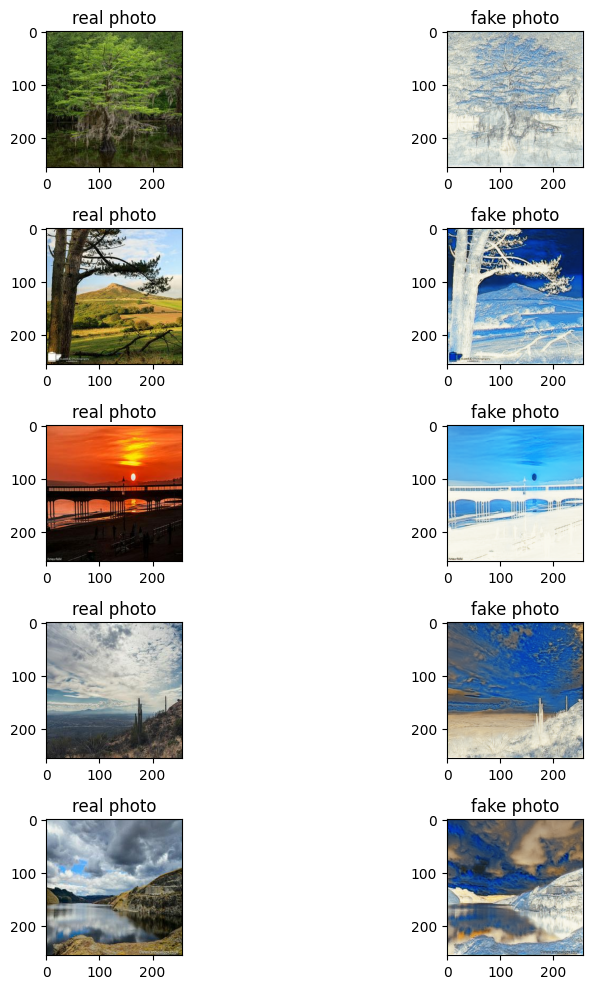

In [34]:
generate_and_compare_images(m_generator_s, photo_df, num_samples=5)

### Complex Model Result Samples

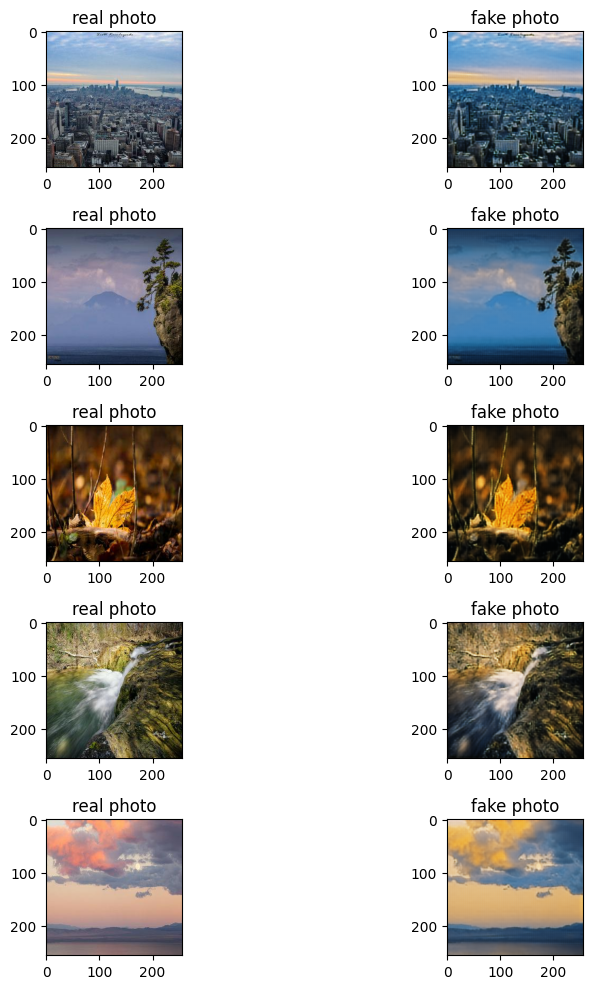

In [35]:
generate_and_compare_images(m_generator, photo_df, num_samples=5)

### Simpler Model Loss Plot

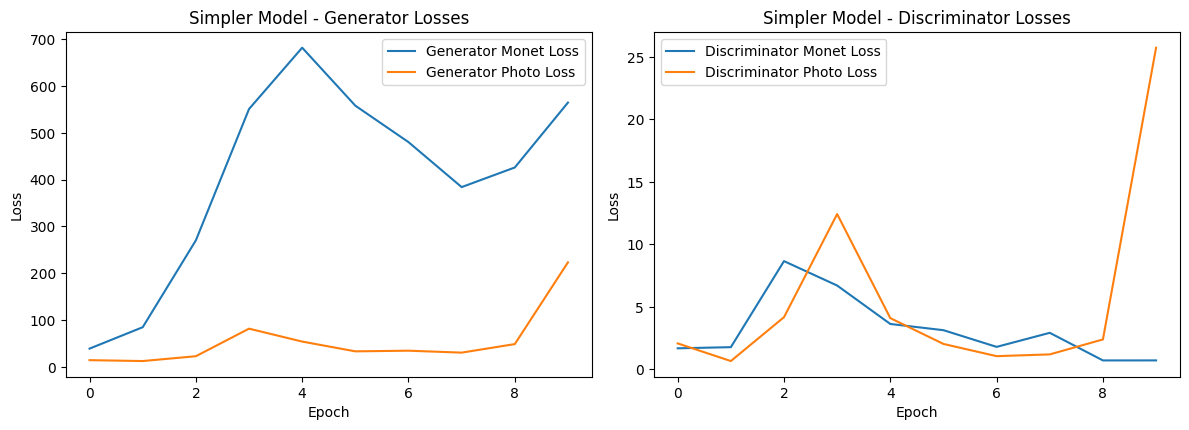

In [36]:
# plot losses
plt.figure(figsize=(12, 8))

# generator loss
plt.subplot(2, 2, 1)
plt.plot(avg_gen_monet_losses_s, label='Generator Monet Loss')
plt.plot(avg_gen_photo_losses_s, label='Generator Photo Loss')
plt.title('Simpler Model - Generator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# discriminator loss
plt.subplot(2, 2, 2)
plt.plot(avg_disc_monet_losses_s, label='Discriminator Monet Loss')
plt.plot(avg_disc_photo_losses_s, label='Discriminator Photo Loss')
plt.title('Simpler Model - Discriminator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Complex Model Loss Plot

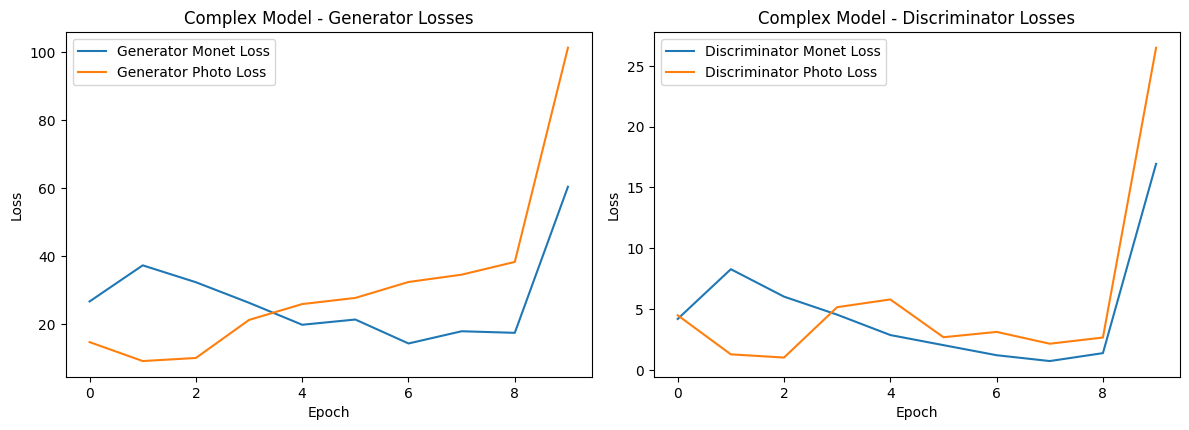

In [37]:
# Plotting the losses
plt.figure(figsize=(12, 8))

# Generator losses
plt.subplot(2, 2, 1)
plt.plot(avg_gen_monet_losses, label='Generator Monet Loss')
plt.plot(avg_gen_photo_losses, label='Generator Photo Loss')
plt.title('Complex Model - Generator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Discriminator losses
plt.subplot(2, 2, 2)
plt.plot(avg_disc_monet_losses, label='Discriminator Monet Loss')
plt.plot(avg_disc_photo_losses, label='Discriminator Photo Loss')
plt.title('Complex Model - Discriminator Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Submission Function

Leveraged code with few tweaks from the tutorial from Amy Jang that is linked in the Kaggle competition overview and referenced in the references section.

*Source: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial*

In [1]:
# function to fit (predict) the test data (photos) and save them for submission
def fit_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        pred = generator_model(img, training=False)[0].numpy() 
        pred = (pred * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(pred)
        im.save(f'{output_path}/{str(i)}.jpg')  # Save image
        i += 1

In [39]:
output = '../images/'

# remove existing images directory and zip file if exists
if os.path.exists(output):
    shutil.rmtree(output)

z_path = '/kaggle/working/images.zip'
if os.path.exists(z_path):
    # remove path if it exists
    os.remove(z_path)

# create the new images directory
os.makedirs(output)

# generate pred and save images to '../images/images.zip'
fit_save(photo_df, m_generator_s, output)

# zip images
shutil.make_archive('/kaggle/working/images', 'zip', output)

# print the number of generated images and to monitor completion
print(f"zipping process completed\nnumber of generated images: {len([name for name in os.listdir(output) if os.path.isfile(os.path.join(output, name))])}")

zipping process completed
number of generated images: 7038


### Kaggle Results <br>
**Version 23:** Simpler model <br>
**Version 14:** Complex model <br>

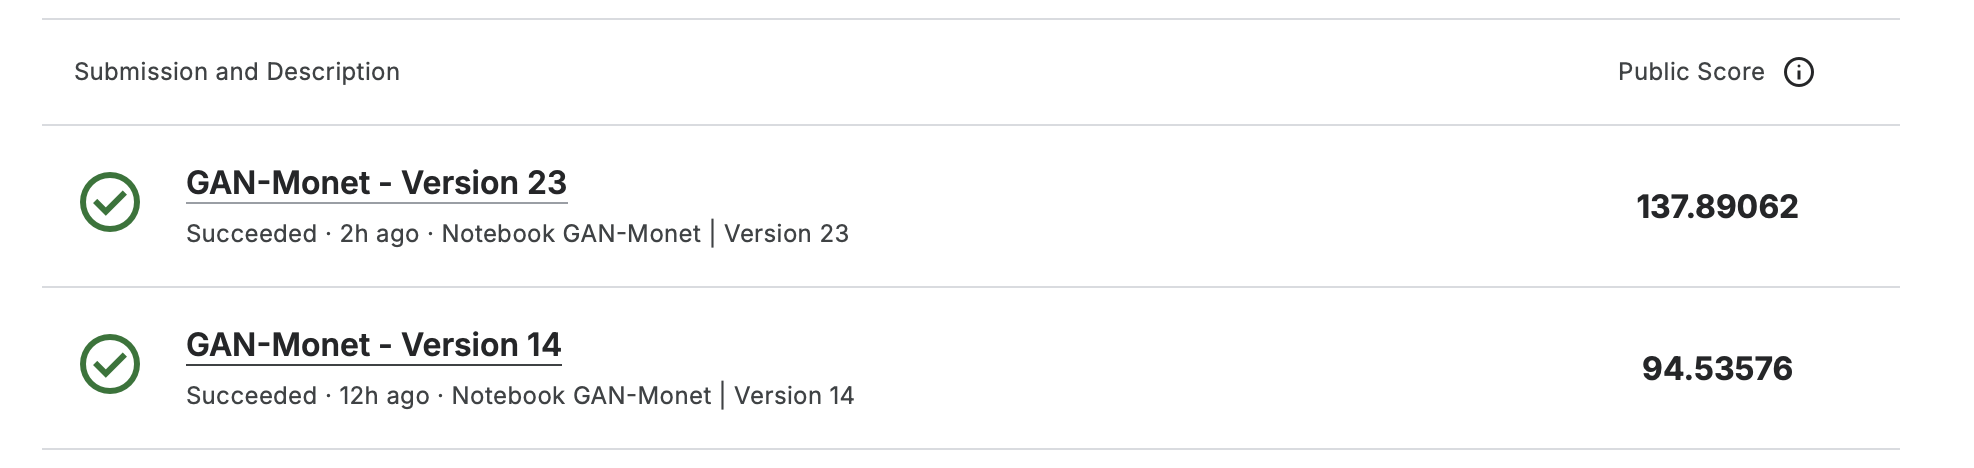

### Conclusion

**Reiteration of results:** <br>
Overall, the results were better than I expected when I first dived into this competition. The complex model performed better, as expected, relative to the simpler model. As outlined earlier, this may be due to the hyperparameter tuning that was done on the images. We can see much better results when we view the actual real photos compared to the monet versions of them. Although with a more complex structure brings risks to overfitting. This was hinted on by the loss function plots discussed earlier. Additionally, as expected the complex model performed better with a score of 94.5 than the simpler model with a score of 137.9. 


**Key takeaways and Learnings:** <br>
Some key takeaways and learnings include understanding the architecture and composition of GAN models, how to hyperparameter tune GAN models, and how the Kaggle framework works. For example, GAN models are not the traditional deep learning models. They have 2 architectures - generator and discriminator - that compete against each other to increase the models performance. The hyperparameters are similar to other deep learning methods, but we can also think outside of this and get creative when working with images such as augmenting the images themselves before we process them through the model step. Lastly, the Kaggle environment and their notebooks was a treat. I enjoyed working within the Kaggle environment and leveraging the GPU to decrease training time as I iterated through a number of versions of my GAN models.

**Discussion of why something didn't work:** <br>
As discussed earlier, some of the things that may have not worked well such as the overfitting of the models may be due to not enough consideration in the hyperparameter tuning. Perhaps, it may be good to research which hyperparameters are good to include to help the training to stabilize more and reduce the overfitting.

**Suggestions for ways to improve:** <br>
For the future, I would put more time in hyperparameter tuning to solve for the overfitting issue that was signaled by the loss plots. Additionally, I would try and run the model without the augment step to see if the performance increases. My thought here is perhaps the augment step crops or zooms too much into an image losing important feature in the training step. Lastly, I would like to see if we can classify the real photos into categories such as landscape, outdoors, people, etc. to see which categories the model struggles with more. Once we identify that, perhaps, we can fine tune our approach to better tailor the model to retrain on those specific categories and improve model performance.

### References:
https://www.kaggle.com/competitions/gan-getting-started <br>
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial <br>
https://www.geeksforgeeks.org/cycle-generative-adversarial-network-cyclegan-2/ <br>
https://numpy.org/doc/stable/ <br>
https://pandas.pydata.org/pandas-docs/stable/ <br>
https://matplotlib.org/stable/contents.html <br>
https://seaborn.pydata.org/ <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.image.html <br>
https://docs.python.org/3/library/random.html <br>
https://opencv.org/documentation/ <br>
https://www.tensorflow.org/api_docs/python/tf <br>
https://www.tensorflow.org/api_docs/python/tf/keras <br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image <br>
https://docs.python.org/3/library/time.html <br>
https://tqdm.github.io/ <br>
https://docs.python.org/3/library/shutil.html <br>
https://docs.python.org/3/library/os.html <br>
https://pillow.readthedocs.io/en/stable/ <br>
https://keras.io/api/backend/ <br>